#### Ulitochka's edit transducer tutorial

### Edit Transducers

An edit transducer is a WFST and thus denotes a weighted relation. For simplicity, we assume that this relation has the domain and range $\Sigma^*$ where $\Sigma$ is the alphabet. We assume further that each pair of strings in the relation (that is, each path) is associated with a non-negative real number weight, and the weight is zero if and only if the input string $s_i$ and the output string $s_o$ are equal.

The edit transducer expresses the various ways in which a string can match, or fail to match, another string drawn from the same alphabet. We decompose this into four character-level operations:

- When an input character and output character are the same, they match; e.g., a matches a
- An output character not present in the input is inserted
- An input character not present in the output is deleted
- When an input character and an output character are different, the latter is substituted for the former; e.g., b is substituted for a

We now proceed to implement these operations as WFSTs.

### Implementing the edit transducer

In [11]:
from __future__ import division

import string  # Demonstration only.

from pynini import acceptor    # Demonstration only.
from pynini import compose
from pynini import invert
from pynini import isomorphic  # Demonstration only.
from pynini import NO_STATE_ID
from pynini import prune
from pynini import shortestdistance
from pynini import shortestpath
from pynini import string_map
from pynini import synchronize
from pynini import transducer
from pynini import union

match

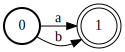

In [2]:
# For simplicity, we assume a two-character alphabet {"a", "b"}.
match = union("a", "b")
match.optimize(True)

insert

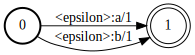

In [3]:
# We use a "1" as a non-zero weight.
insert = transducer("", match, weight=1)
insert.optimize(True)

Delete

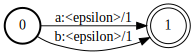

In [4]:
delete = transducer(match, "", weight=1)
# Or, equivalently: delete = invert(insert)
delete.optimize(True)

Substitude

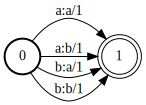

In [5]:
#the synchronize function helps to remove unnecessary epsilon arcs
substitute = synchronize(transducer(match, match, weight=1))
substitute.optimize(True)

Union of Four operations

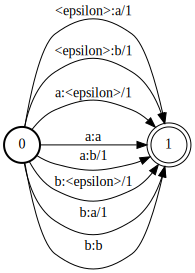

In [6]:
ops = union(match, delete, insert, substitute)
ops.optimize(True)

The ops transducer currently only accepts zero or one elements of $\Sigma$, whereas we want a transducer over the infinite set $\Sigma^{*}$. To do this, we compute its (concatenative) closure:

In [7]:
edit = ops.closure().optimize()

If you get an error "FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'"
Sol: Try installing sudo apt-get install graphviz in usr/lib

### Applying the Edit Transducers

To "apply" the relation expressed by the edit transducer, we first compose the input string $s_i$ with the left side of the edit transducer. The composition operation is a generalization of set intersection. When we compose an acceptor with the left size of a transducer, we are essentially intersecting the set denoted by the acceptor (here a single string) with the domain of the transducer, producing a WFST denoting a relation from $\{s_i\}$ to $\Sigma^{*}$.

We then compose the resulting transducer with the output string $s_o$. When we compose a the right size of a transducer an acceptor, we are intersecting the set denoted by the range of the transducer with the set denoted by the acceptor (here a single string). This produces a WFST denoting a relation from $\{s_i\}$ to $\{s_o\}$. We refer to this as the lattice:

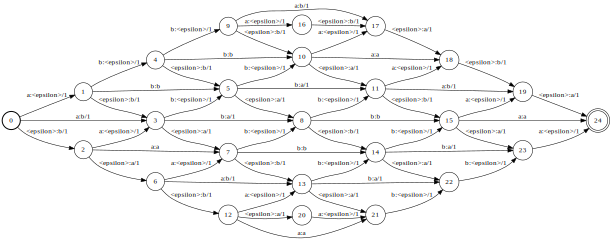

In [8]:
s_i = "abba"
s_o = "baba"
lattice = compose(compose(s_i, edit), s_o)
lattice

Every path in this lattice is a possible alignment of the string abba to the string baba, and the cost of that path is the edit distance for that alignment. when visualizing the lattice, which can be a relatively large WFST, it is sometimes helpful to first "prune" it so that it contains only the optimal paths:

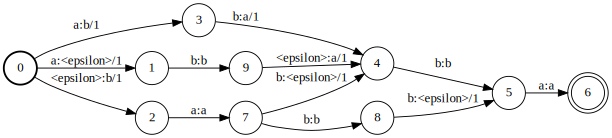

In [9]:
prune(lattice, weight = 0)


If we take the path $[0, 3, 4, 5, 6]$, along the top of the graph, we obtain the following alignment, with two matches and two substitutions:

   - abba
   - baba

If, however, we take the path $[0, 2, 7, 8, 5, 6]$, along the bottom of the graph, we obtain the following alignment, with two matches, one insertion, and one deletion:

   - _abba
   - bab_a

Both of these paths have the same cost (2) and thus are present in the pruned lattice of optimal paths. Note of course that the optimal pat ths depend on the costs we assign to the different edit operations. If, for instance, we had assigned a zero cost to insertions and a unit cost to deletions and substitution, the former path above would no longer be optimal and the latter path would have a cost of 1.

### Edit-Transducers for larger vocabularies

The previous example above used a small (two-symbol) alphabet, as was the resulting transducer. However, the size of the transducer will grow quadratically as a function of the alphabet size. While this is still manageable for the 27 lowercase characters of English or the 95 printable ASCII characters—the resulting machine will have 9,215 arcs using the above formulation—but more than four billion arcs will be needed for the 65,536 code points of the Unicode Basic Multilingual Plane. This is clearly not feasible.

Fortunately, there is a way to trick to avoid quadratic growth: we factor the edit transducer into two smaller machines. Above, we computed the lattice $L$ for a pair of strings strings $s_i, s_o$ as follows:

$$L = s_i~\circ~\mathcal{E}~\circ~s_o$$
where $\mathcal{E}$ is the edit transducer and $\circ$ is the composition operator. We factor $\mathcal{E}$ into two smaller transducers $\mathcal{E}_i$ and $\mathcal{E}_o$ such that $\mathcal{E}_i~\circ~\mathcal{E}_o$ is isomorphic to the original $\mathcal{E}$. We can compute a new lattice $L'$ as follows:

$$L' = (s_i~\circ~\mathcal{E}_i)~\circ~(\mathcal{E}_o~\circ~s_o)$$
Because $\mathcal{E}_i~\circ~\mathcal{E}_o$ is isomorphic to $\mathcal{E}$, and composition is associative, $L$ and $L'$ will also be isomorphic.

Not all regular relations can be factored into two smaller machines, but it is straightforward to do so for the edit transducer above. The basic insight is that instead of enumerating all the possible substitutions (or insertions, or deletions), we treat edits as a two-part process. In the case of substitution, we first map each input symbol to a special < substition > symbol in the left factor $\mathcal{E}_i$, and then mapping this special symbol to an output symbol in the right factor $\mathcal{E}_o$. Similar tricks can be applied to the insertion and deletion operations. As a result, the size of the two factors is a linear —rather than quadratic—function of alphabet size.

We now proceed to construct the two factors, focusing on the input-side factor $\mathcal{E}_i$ first and then transforming it to generate $\mathcal{E}_o$. For both factors, the match operation is implemented as before: an unweighted union over the alphabet. Note that we halve the costs in  $\mathcal{E}_i$ because the cost will also be incurred a second time as the path traverses $\mathcal{E}_o$.

The insert operation maps from epsilon to a reserved symbol < insert > with a cost of 1/2:

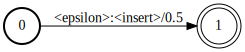

In [12]:
# The square brackets cause the string to be interpreted as a "reserved" symbol.
i_insert = transducer("", "[<insert>]", weight=1/2)
i_insert.optimize(True)

The delete and the substitute operations map from the input alphabet to < delete > and to < substitute >, respectively, with a cost of 1/2:

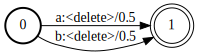

In [13]:
i_delete = transducer(match, "[<delete>]", weight=1/2)
# We have to optimize twice to get the minimal machine.
i_delete.optimize(True).optimize(True)

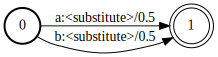

In [14]:
i_substitute = transducer(match, "[<substitute>]", weight=1/2)
# Ditto.
i_substitute.optimize(True).optimize(True)

Then, we put the four left-factor operations together:

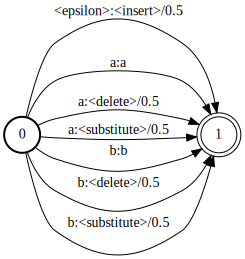

In [15]:
i_ops = union(match, i_insert, i_delete, i_substitute)
i_ops.optimize(True)

For the right factor $\mathcal{E}_o$, we need an insert operation which maps from < insert > to the alphabet, a delete operation which maps from < delete > to epsilon, and so on. Rather than building these directly, we can construct the entire set of right operations by inverting the left factor and then swapping < insert > and < delete > with relabel_pairs. This first requires us to look up the integer labels associated with these special symbols:

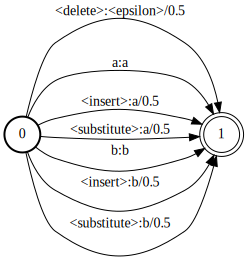

In [16]:
o_ops = invert(i_ops)
syms = o_ops.input_symbols()
insert_label = syms.find("<insert>")
delete_label = syms.find("<delete>")
o_ops.relabel_pairs(ipairs=((insert_label, delete_label),
                                   (delete_label, insert_label)))

Finally, we compute the closures of the two sets of operations and optimize:

In [17]:
e_i = i_ops.closure().optimize(True)
e_o = o_ops.closure().optimize(True)

In [22]:
factored_edit = compose(e_i, e_o)
factored_edit.optimize(True)
assert isomorphic(edit, factored_edit) # testing similarity

And, as we can see below, this construction produced a pruned lattice isomorphic to the one above:

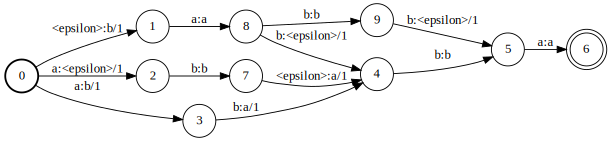

In [155]:
i_edit = compose(s_i, e_i)
o_edit = compose(e_o, s_o)
prune(compose(i_edit, o_edit), weight = 0)


We now proceed to wrap this into a class called EditTransducer. We expose the following parameters to the user:

- the alphabet (an iterable of strings)
- the cost of insertion (defaulting to 1)
- the cost of deletion (defaulting to 1)
- the cost of substitution (defaulting to 1)

In addition to a constructor which builds the two factors, we add a method which builds the lattice for a pair of strings, and a static method which checks that a lattice is well-formed (i.e., has a valid start state). If the lattice is illformed, this indicates that one or more characters in the input and/or output string is not in the provided alphabet. Since most operations will be undefined in this case, an exception is thrown. This class is given below:

In [161]:
DEFAULT_INSERT_COST = 1
DEFAULT_DELETE_COST = 1
DEFAULT_SUBSTITUTE_COST = 1

class LatticeError(Exception):
    pass

class EditTransducer():
    """Factored edit transducer.

    This class stores the two factors of an finite-alphabet edit transducer and
    supports insertion, deletion, and substitution operations with user-specified
    costs.

    Note that the cost of substitution must be less than the cost of insertion
    plus the cost of deletion or no optimal path will include substitution.
    """

    # Reserved labels for edit operations.
    DELETE = "<delete>"
    INSERT = "<insert>"
    SUBSTITUTE = "<substitute>"

    def __init__(self,
            alphabet,
            insert_cost=DEFAULT_INSERT_COST,
            delete_cost=DEFAULT_DELETE_COST,
            substitute_cost=DEFAULT_SUBSTITUTE_COST):
        """Constructor.

        Args:
          alphabet: edit alphabet (an iterable of strings).
          insert_cost: the cost for the insertion operation.
          delete_cost: the cost for the deletion operation.
          substitute_cost: the cost for the substitution operation.
        """
        # Left factor; note that we divide the edit costs by two because they also
        # will be incurred when traversing the right factor.
        match = union(*alphabet).optimize(True)
        i_insert = transducer("", "[{}]".format(self.INSERT),
                              weight=insert_cost / 2).optimize(True)
        i_delete = transducer(match, "[{}]".format(self.DELETE),
                              weight=delete_cost / 2).optimize(True)
        i_substitute = transducer(match, "[{}]".format(self.SUBSTITUTE),
                                  weight=substitute_cost / 2).optimize(True)
        i_ops = union(match, i_insert, i_delete, i_substitute).optimize(True)
        # Right factor; this is constructed by inverting the left factor (i.e.,
        # swapping the input and output labels), then swapping the insert and delete
        # labels on what is now the input side.
        o_ops = invert(i_ops)
        syms = o_ops.input_symbols()
        insert_label = syms.find(self.INSERT)
        delete_label = syms.find(self.DELETE)
        o_ops.relabel_pairs(ipairs=((insert_label, delete_label),
                                    (delete_label, insert_label)))
        # Computes the closure for both sets of ops.
        self._e_i = i_ops.closure().optimize(True)
        self._e_o = o_ops.closure().optimize(True)
        
    @staticmethod
    def check_wellformed_lattice(lattice):
        """Raises an error if the lattice is empty.

        Args:
          lattice: A lattice FST.

        Raises:
          LatticeError: Lattice is empty.
        """
        if lattice.start() == NO_STATE_ID:
            raise LatticeError("Lattice is empty")

    def _create_lattice(self, iset, oset):
        """Creates edit lattice for a pair of input/output strings or acceptors.

        Args:
          iset: input string or acceptor
          oset: output string or acceptor.

        Returns:
          A lattice FST.
        """
        l_i = compose(iset, self._e_i)
        l_o = compose(self._e_o, oset)
        lattice = compose(l_i, l_o)
        EditTransducer.check_wellformed_lattice(lattice)
        return lattice

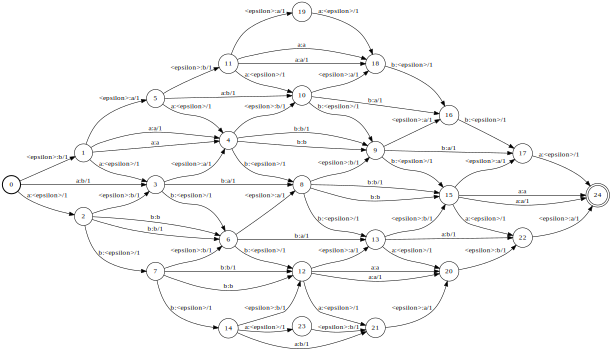

In [159]:
a = EditTransducer("ab")
a._create_lattice("abba", "baba")

### From edit transducers to Levenshtein distance

The above class constructs the two factors of the edit transducer, and then applies them to input/output strings or sets to create the lattice. But the lattice does not direclty measure the similarity of the input and output string. To compute that, we compute the shortest distance from all final state to the start state—the cost of the shortest path through the lattice. With default weights, this will simply be the minimal number of insertions, deletions, and substitutions needed to align the two strings; this metric is known as Levenshtein distance. We implement this below by deriving a new class, LevenshteinDistance, from the EditTransducer base class:

In [113]:
class LevenshteinDistance(EditTransducer):
    """Edit transducer augmented with a distance calculator."""

    def distance(self, iset, oset):
        """Computes minimum distance.

        This method computes, for a pair of input/output strings or acceptors, the
        minimum edit distance according to the underlying edit transducer.

        Args:
          iset: input string or acceptor.
          oset: output string or acceptor.

        Returns:
        Minimum edit distance according to the edit transducer.
        """
        lattice = self._create_lattice(iset, oset)
        start_state = lattice.start()
        # The shortest cost from all final states to the start state is
        # equivalent to the cost of the shortest path.
        return float(shortestdistance(lattice, reverse=True)[start_state])

The following example shows computation of edit distance for the strings abba, baba, which as we saw above, is 2.0 using the default costs.

In [162]:
ld = LevenshteinDistance(("a", "b"))
assert ld.distance(s_i, s_o) == 2.0